# Line-level text detection with Surya

> **Note:** This notebook has been moved to a new branch named "latest". [Click here](https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/notebooks/surya-line-level-text-detection/surya-line-level-text-detection.ipynb) to get the most updated version of the notebook. This branch is deprecated.

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/openvinotoolkit/openvino_notebooks/blob/main/notebooks/285-surya-line-level-text-detection/285-surya-line-level-text-detection.ipynb)

In this tutorial we will perform line-level text detection using [Surya](https://github.com/VikParuchuri/surya) toolkit and OpenVINO.

![line-level text detection](https://github.com/VikParuchuri/surya/blob/master/static/images/excerpt.png?raw=true)

[**image source*](https://github.com/VikParuchuri/surya)


Model used for line-level text detection based on [Segformer](https://arxiv.org/pdf/2105.15203.pdf). It has the following features:
* It is specialized for document OCR. It will likely not work on photos or other images.
* It is for printed text, not handwriting.
* The model has trained itself to ignore advertisements.
* Languages with very different character sets may not work well.


#### Table of contents:

- [Fetch test image](#Fetch-test-image)
- [Run PyTorch inference](#Run-PyTorch-inference)
- [Convert model to OpenVINO Intermediate Representation (IR) format](#Convert-model-to-OpenVINO-Intermediate-Representation-(IR)-format)
- [Run OpenVINO model](#Run-OpenVINO-model)
- [Interactive inference](#Interactive-inference)



## Fetch test image
[back to top ⬆️](#Table-of-contents:)

We will use an image from a randomly sampled subset of [DocLayNet](https://github.com/DS4SD/DocLayNet) dataset.

> **NOTE**: This notebook uses [surya-ocr](https://pypi.org/project/surya-ocr/) package which requires python version >=3.9

In [ ]:
%pip install -q --extra-index-url https://download.pytorch.org/whl/cpu "openvino>=2023.3.0" "transformers[torch]" "surya-ocr==0.1.6" datasets gradio

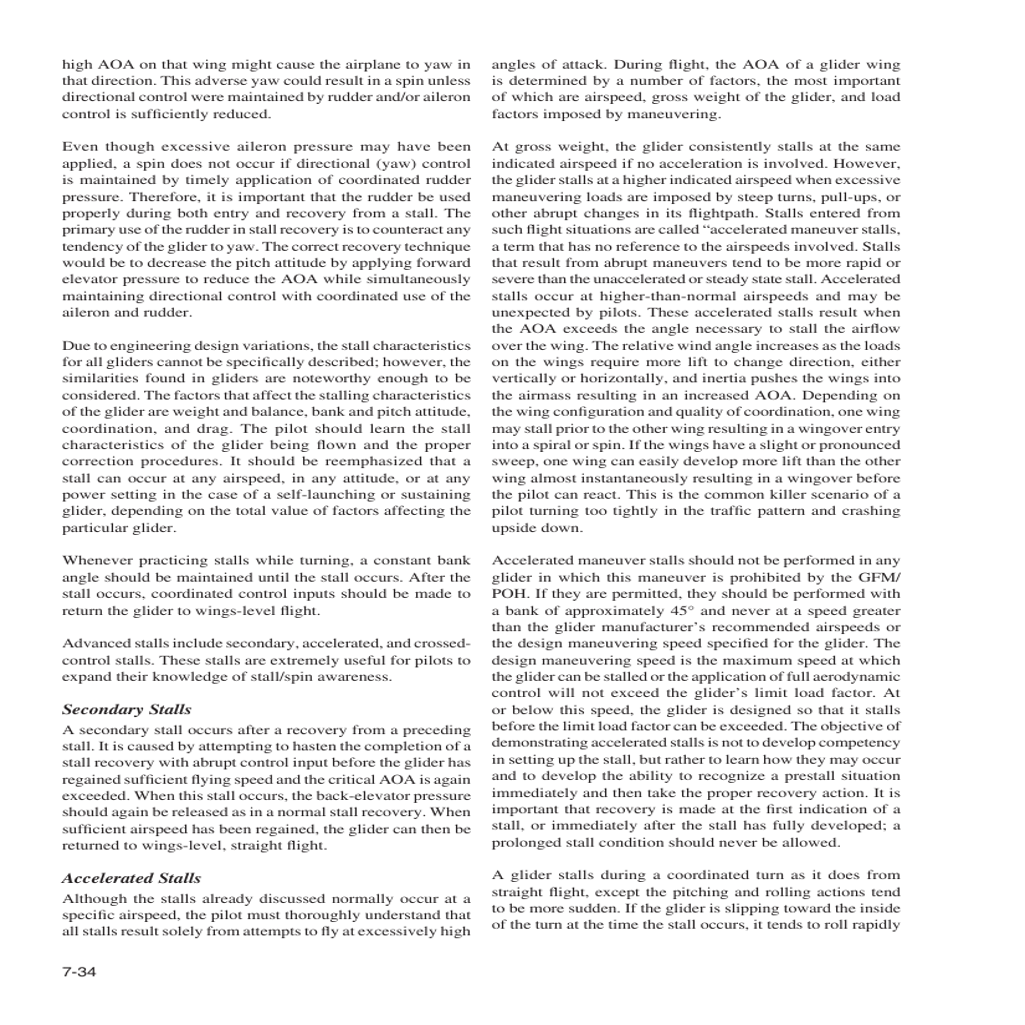

In [2]:
from datasets import load_dataset


def fetch_image():
    dataset = load_dataset("vikp/doclaynet_bench", split="train", streaming=True)
    return next(iter(dataset))["image"]


test_image = fetch_image()
test_image

## Run PyTorch inference
[back to top ⬆️](#Table-of-contents:)

To perform line-level text detection we will use `load_model` and `load_processor` functions from `surya` package. We will also use `batch_inference` function which performs pre and post processing.

In [3]:
# Predictions visualization function
from PIL import ImageDraw


def visualize_prediction(image, prediction):
    image = image.copy()
    draw = ImageDraw.Draw(image)

    for bbox in prediction["bboxes"]:
        draw.rectangle(bbox, width=1, outline="red")

    display(image)

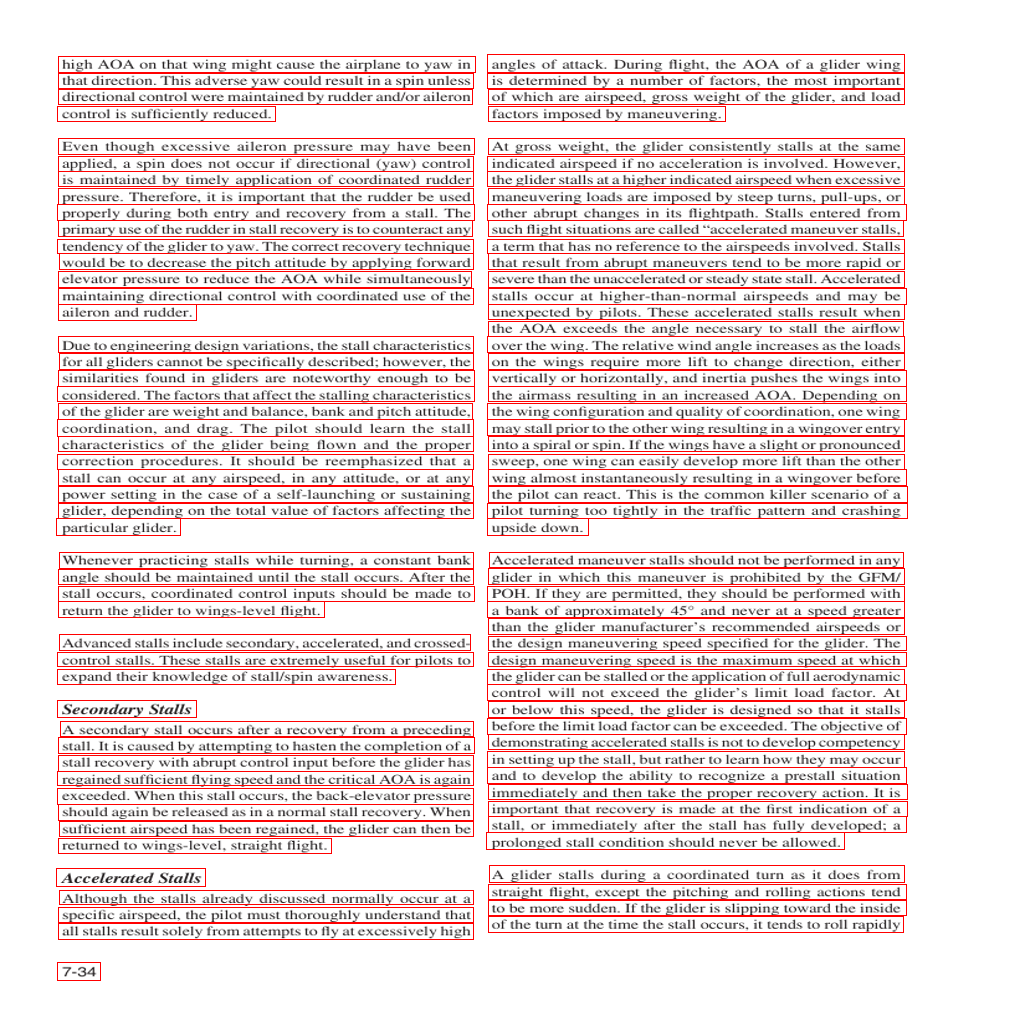

In [4]:
from surya.detection import batch_inference
from surya.model.segformer import load_model, load_processor

model, processor = load_model(), load_processor()

predictions = batch_inference([test_image], model, processor)

visualize_prediction(test_image, predictions[0])

## Convert model to OpenVINO Intermediate Representation (IR) format
[back to top ⬆️](#Table-of-contents:)

For best results with OpenVINO, it is recommended to convert the model to OpenVINO IR format. OpenVINO supports PyTorch via Model conversion API.
To convert the PyTorch model to OpenVINO IR format we will use `ov.convert_model` of [model conversion API](https://docs.openvino.ai/2024/openvino-workflow/model-preparation.html). The `ov.convert_model` Python function returns an OpenVINO Model object ready to load on the device and start making predictions.

`ov.convert_model` requires a sample of original model input. We will use image pre-processing from `surya` package to prepare example input.

In [5]:
# Build example input
from surya.model.processing import prepare_image
import torch


def build_example_input(image, processor):
    input_values = prepare_image(image.convert("RGB"), processor)

    return {"pixel_values": torch.unsqueeze(input_values, 0)}


example_input = build_example_input(test_image, processor)

In [6]:
# Convert model
import openvino as ov

ov_model = ov.convert_model(model, example_input=example_input)

## Run OpenVINO model
[back to top ⬆️](#Table-of-contents:)

Select device from dropdown list for running inference using OpenVINO

In [7]:
import ipywidgets as widgets

core = ov.Core()

device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='AUTO',
    description='Device:',
    disabled=False,
)

device

Dropdown(description='Device:', index=1, options=('CPU', 'AUTO'), value='AUTO')

We want to reuse model results postprocessing implemented in `batch_inference` function. In order to do that we implement simple wrappers for OpenVINO model with interface required by `batch_inference` function.

In [9]:
core = ov.Core()

# Compile OpenVINO model for loading on device
compiled_ov_model = core.compile_model(ov_model, device.value)


class OVModelWrapperResult:
    def __init__(self, logits):
        self.logits = logits


class OVModelWrapper:
    dtype = torch.float32
    device = model.device

    def __call__(self, **kwargs):
        # obtain output tensor for getting predictions
        logits_out = compiled_ov_model.output(0)
        # run inference on preprocessed data and get image-text similarity score
        logits = compiled_ov_model(kwargs)[logits_out]
        return OVModelWrapperResult(torch.from_numpy(logits))


ovModelWrapper = OVModelWrapper()

ov_predictions = batch_inference([test_image], ovModelWrapper, processor)

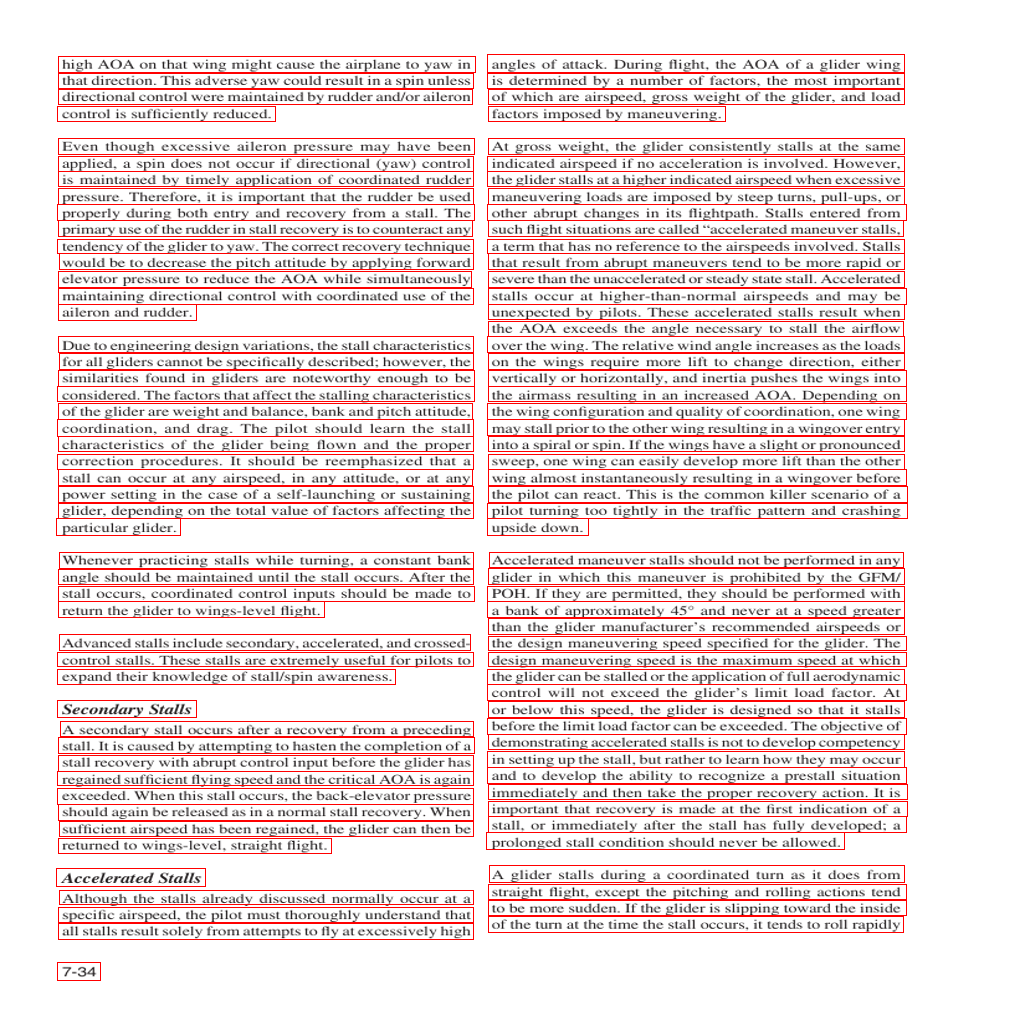

In [10]:
visualize_prediction(test_image, ov_predictions[0])

## Interactive inference

[back to top ⬆️](#Table-of-contents:)

Now, it is your turn! Feel free to upload an image, using the file upload window.

In [ ]:
import gradio as gr


def predict(image):
    predictions = batch_inference([image], ovModelWrapper, processor)

    image = image.copy()
    draw = ImageDraw.Draw(image)

    for bbox in predictions[0]["bboxes"]:
        draw.rectangle(bbox, width=1, outline="red")

    return image


demo = gr.Interface(
    predict,
    gr.Image(label="Image", type="pil"),
    gr.Image(label="Result"),
    examples=[test_image],
)
try:
    demo.launch(debug=True, height=1000)
except Exception:
    demo.launch(share=True, debug=True, height=1000)
# if you are launching remotely, specify server_name and server_port
# demo.launch(server_name='your server name', server_port='server port in int')
# Read more in the docs: https://gradio.app/docs/